In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.core import Dropout, Flatten, Dense
from keras.layers import BatchNormalization,Concatenate
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import glob
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
# Set some parameters
os.chdir('/depot/wwtung/data/Brittoa/Kaggle/understanding_cloud_organization')

im_width = 1400
im_height = 2100
im_chan = 3
train_ids = glob.glob("train_images/*.jpg")

In [3]:
X_train = np.zeros((len(train_ids), im_width, im_height, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    img = load_img(train_ids[n])
    x = img_to_array(img)
    x = resize(x, (im_width, im_height, im_chan), mode='constant', preserve_range=True)
    
    X_train[n] = x
    #mask = img_to_array(load_img(path + '/masks/' + id_))
    #Y_train[n] = resize(mask, (im_width, im_height, im_chan), mode='constant', preserve_range=True)
    print(n, id_)
print('Done!')

Getting and resizing train images and masks ... 


0 train_images/833fbba.jpg
1 train_images/25500bf.jpg
2 train_images/3fc1779.jpg
3 train_images/e1723b2.jpg
4 train_images/c3014c1.jpg
5 train_images/0cabeda.jpg
6 train_images/faf4960.jpg
7 train_images/10ed18e.jpg
8 train_images/dbea334.jpg
9 train_images/af9bb8e.jpg



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/brittoa/.conda/envs/cent7/5.3.1-py37/weatherconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-5f130da8a410>", line 6, in <module>
    img = load_img(train_ids[n])
  File "/home/brittoa/.conda/envs/cent7/5.3.1-py37/weatherconda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py", line 110, in load_img
    img = pil_image.open(path)
  File "/home/brittoa/.conda/envs/cent7/5.3.1-py37/weatherconda/lib/python3.7/site-packages/PIL/Image.py", line 2766, in open
    fp = builtins.open(filename, "rb")
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/brittoa/.conda/envs/cent7/5.3.1-py37/weatherconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2034, in showtraceback
    stb = value._render_traceback_()
Attri

KeyboardInterrupt: 

In [4]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(1400, 2100, 3))



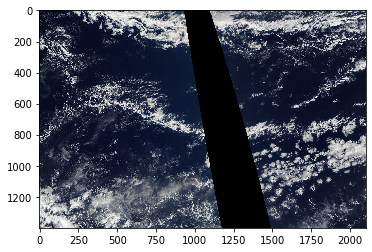

In [5]:
plt.imshow(X_train[0])
x = resize(X_train[0], (1, im_width, im_height, im_chan))


In [6]:
x_c = conv_base.predict(x)
print(x_c.shape)

(1, 43, 65, 512)


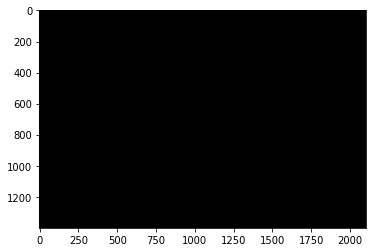

(2100, 1400, 1)
(2100, 1400)


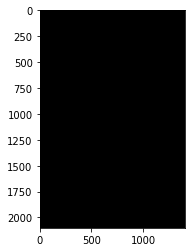

In [7]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
#print(ix)
#print(X_train[ix].shape)
#print(np.dstack((X_train[ix],X_train[ix],X_train[ix])).shape)
plt.imshow((X_train[ix]))
plt.show()
print(Y_train[ix].shape)
print(np.squeeze(Y_train[ix]).astype(np.float32).shape)
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [8]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [9]:
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.2, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [10]:
im_height = 2100 
im_width = 1400
im_chan = 1
img_shape = (im_height, im_width, im_chan)
inputs = Input(img_shape)
s = Lambda(lambda x: x / 255) (inputs)

In [11]:
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

NameError: name 'unet' is not defined

In [ ]:
def unet(pretrained_weights = None,input_size = (1024,2048,3)):
    from keras.applications import VGG16

    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(1024, 2028, 3))
    inputs = Input(input_size)
    conv0 = (conv_base)(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv11 = Flatten()(conv10)
    #conv12 = Dense(1, activation='sigmoid')(conv11)
    model = Model(input = inputs, output = conv10)

    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [ ]:
model = unet()

In [ ]:
#model.add(Dense(183750, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

In [ ]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('modeltest.h5', verbose=1, save_best_only=True)
#results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=100, 
#                     callbacks=[checkpointer])
                     #callbacks=[earlystopper, checkpointer])

In [14]:
trainOutput = pd.read_csv("train.csv")
X_train = np.zeros((100, 1024, 2*1024, 3), dtype=np.uint8)
x = 0
images = train_ids
FiLabels = []
while(x < 100):
    imagePath = x
    #data = []
    if imagePath > 5545:
        break
    imageNum = imagePath
    print(imageNum, "of", len(images))
    #dataInput =(np.array(cv2.imread(images[imageNum],0)))
    #dataInput = cv2.resize(dataInput, (2048, 1024))
    #data.append(np.array(dataInput))
    #print(len(data))
    img = load_img(images[imageNum])
    X = img_to_array(img)
    X = resize(X, (1024, 2*1024, 3), mode='constant', preserve_range=True)
    X_train[imageNum] = X
    Num = images[imageNum]
    imagecharFish = trainOutput[trainOutput['Image_Label']==(Num[13:]+'_Fish')]
    outputFish = list(imagecharFish['EncodedPixels'])
    if isinstance(outputFish[0], float) != True:
        OutputCleanFish = np.array(OutputMaker(outputFish))
        FiLabels.append(OutputCleanFish.reshape(2048*1024))
        print(imageNum)
    else:
        FiLabels.append(np.zeros(2048*1024))
    #data =X_train / 255 #Scales data
    #print(data.shape)
    #FiLabels = np.array(FiLabels)
    x = x+1
#train_XFi,valid_XFi,train_YFi,valid_YFi = train_test_split(data, FiLabels, 
                                                               #test_size=0.2, 
                                                               #random_state=13)
    #train_XFi = train_XFi.reshape(-1, 350,525, 1)
    #valid_XFi = valid_XFi.reshape(-1,350,525, 1)
print("[INFO] training network...")

0 of 5546
0
1 of 5546
2 of 5546
2
3 of 5546
4 of 5546
4
5 of 5546
5
6 of 5546
6
7 of 5546


KeyboardInterrupt: 

In [13]:
def OutputMaker(output):
    output = output[0].split()
    CleanOutput = output
    Fix = np.zeros((350*4,525*4))
    for Y in range(0, int(len(CleanOutput)/2)):
        #print(Y, len(CleanOutput)/2)
        #print(CleanOutput[2*Y], CleanOutput[2*Y+1])
        #print(int(CleanOutput[2*Y]/350))
        #print(CleanOutput[2*Y]%350)
        Overflow = 0
        for value in range(0,int(CleanOutput[2*Y+1])):
            position = int(CleanOutput[2*Y])%(350*4) + value - Overflow*350*4
            #print(position)
            if position >= 350*4:
                Overflow = Overflow + 1
                position = int(CleanOutput[2*Y])%(350*4) + value - Overflow*350*4
            #print(position,int(CleanOutput[2*Y]/350)+Overflow-1)
            Fix[position,int(int(CleanOutput[2*Y])/(350*4))+Overflow-1] = 1
    Fix = cv2.resize(Fix, (2048, 1024))
    return(Fix) 

In [15]:
data = X_train/255
FiLabels = np.array(FiLabels)
data = data.reshape(-1, 1024,2048, 3)
print(data.shape)
FiLabels = FiLabels.reshape(-1,1024,2048, 1)
results = model.fit(data,FiLabels, validation_split=0.1, batch_size=8, epochs=100, 
#                     callbacks=[checkpointer])
                     callbacks=[earlystopper, checkpointer])

(100, 1024, 2048, 3)


NameError: name 'model' is not defined

In [ ]:
2940000/1400

In [ ]:
data.shape

/home/brittoa/.conda/envs/cent7/5.3.1-py37/weatherconda/lib/python3.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log
/home/brittoa/.conda/envs/cent7/5.3.1-py37/weatherconda/lib/python3.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide


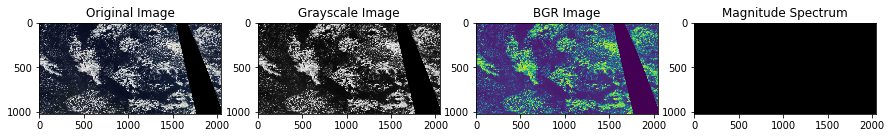

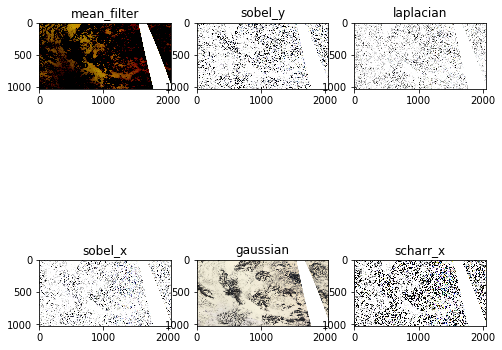

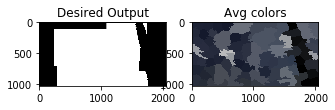

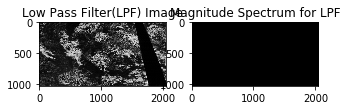

TypeError: imshow() missing 1 required positional argument: 'arr'

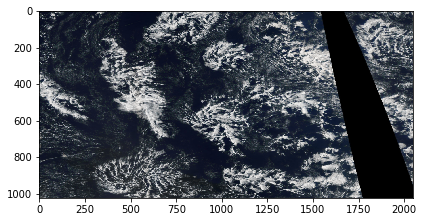

In [16]:
import cv2 as cv 
TESTNUM = 2
FiLabels = FiLabels.reshape(-1,1024,2048)
#ix = random.randint(0, 4000)
img = X_train[TESTNUM]
img_orig = np.copy(img)

bgrimg = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# reshaping the image
#img = resize(img, (128, 128, 3)) #, mode='constant', preserve_range=True)
grayimg = np.copy(img[:, :, 0])
#bgrimg = resize(bgrimg, (128, 128, 3)) #, mode='constant', preserve_range=True)

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = np.log(np.abs(fshift + 1)) 
mx = np.max(np.abs(magnitude_spectrum))
mn = np.min(np.abs(magnitude_spectrum))
ms = (mx - magnitude_spectrum) / (mx - mn) 


f, ax = plt.subplots(1,4, figsize=(15,15))
ax[0].imshow(img_orig)
ax[0].set_title('Original Image')

ax[1].imshow(grayimg, cmap='gray')
ax[1].set_title('Grayscale Image')
ax[2].imshow(bgrimg)
ax[2].set_title('BGR Image')
ax[3].imshow(ms)
ax[3].set_title('Magnitude Spectrum')
plt.show()

# Low Pass Filter
# create a mask first, center square is 1, remaining all zeros
rows, cols = grayimg.shape
crow, ccol = int(rows/2) , int(cols/2)      # center
fs = int(rows* 0.15)

mask = np.zeros((rows, cols, 2), np.uint8)
mask[crow-fs:crow+fs, ccol-fs:ccol+fs] = 1

# apply mask and inverse DFT
img_float32 = np.float32(grayimg)

dft = cv.dft(img_float32, flags = cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
mfshift = dft_shift*mask
magnitude_spectrum2 = np.log(np.abs(mfshift + 1)) 
mx2 = np.max(np.abs(magnitude_spectrum2))
mn2 = np.min(np.abs(magnitude_spectrum2))
ms2 = (mx2 - magnitude_spectrum2) / (mx2 - mn2) 


mf_ishift = np.fft.ifftshift(mfshift)
img_back = cv.idft(mf_ishift)
img_back = cv.magnitude(img_back[:,:,0],img_back[:,:,1])


import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

# simple averaging filter without scaling parameter
mean_filter = np.ones((3,3))

# creating a guassian filter
x = cv2.getGaussianKernel(5,10)
gaussian = x*x.T

# different edge detecting filters
# scharr in x-direction
scharr = np.array([[-3, 0, 3],
                   [-10,0,10],
                   [-3, 0, 3]])
# sobel in x direction
sobel_x= np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
# sobel in y direction
sobel_y= np.array([[-1,-2,-1],
                   [0, 0, 0],
                   [1, 2, 1]])
# laplacian
laplacian=np.array([[1, 0, 1],
                    [0,-4, 0],
                    [1, 0, 1]])

filter_num = 6
filters = [mean_filter, gaussian, laplacian, sobel_x, sobel_y, scharr]
filter_name = ['mean_filter', 'gaussian','laplacian', 'sobel_x', \
                'sobel_y', 'scharr_x']
fft_filters = [np.fft.fft2(x) for x in filters]
fft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in fft_shift]


f, ax = plt.subplots(2, 3, figsize=(8, 8))
for i in range(filter_num):
    rx = ((i+1) % 2) - 1
    ry = ((i+1) % 3) - 1
    f_img = cv.filter2D(img, -1, filters[i])
    mx = np.max(np.abs(f_img))
    mn = np.min(np.abs(f_img))
    f_img = (mx - f_img) / (mx - mn)
    ax[rx][ry].imshow(f_img,cmap = 'gray')
    ax[rx][ry].set_title(filter_name[i])
plt.show()
image_slic = seg.slic(img,n_segments=155)

f, ax = plt.subplots(1,2, figsize=(5, 5))
ax[0].imshow(FiLabels[TESTNUM], cmap='gray')
ax[0].set_title('Desired Output')
ax[1].imshow(color.label2rgb(image_slic, img, kind='avg'))
ax[1].set_title('Avg colors')
plt.show()
f, ax = plt.subplots(1,2, figsize=(5, 5))
ax[0].imshow(img_back, cmap='gray')
ax[0].set_title('Low Pass Filter(LPF) Image')
ax[1].imshow(ms)
ax[1].set_title('Magnitude Spectrum for LPF')
plt.show()
imshow(ndimage.median_filter(img, 3))
#imgN = cv.imread(path_train + 'images/' + train_ids[ix]) #cv.cvtColor(img_orig, cv.COLOR_GRAY2RGB) #cv.cvtColor(img, cv2.COLOR_BGR)
#mask = np.zeros(imgN.shape[:2],np.uint8)
imshow()
#bgdModel = np.zeros((1,65),np.float64)
#fgdModel = np.zeros((1,65),np.float64)

#rect = (50,50,450,290)
#cv.grabCut(imgN,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)

#mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
#newimg = imgN*mask2[:,:,np.newaxis]

#plt.imshow(newimg),plt.colorbar(),plt.show()


In [ ]:
FiLabels.shape

In [ ]:
FiLabels[1].shape

In [ ]:
imshow(FiLabels[2])

In [ ]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from keras.models import model_from_json
import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.core import Dropout, Flatten, Dense
from keras.layers import BatchNormalization,Concatenate
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import glob
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img






In [ ]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)
def unet(pretrained_weights = None,input_size = (1024,2048,3)):
    from keras.applications import VGG16

    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(1024, 2048, 3))
    
   
    inputs =Input(input_size)
    conv0= (conv_base)(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv11 = Flatten()(conv10)
    #conv12 = Dense(1, activation='sigmoid')(conv11)
    model = Model(input = inputs, output = conv10)

    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model


In [ ]:
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

In [ ]:
vgg16

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(1024, 2048, 3))

In [ ]:
conv_base.summary()

TypeError: missing a required argument: 'X'

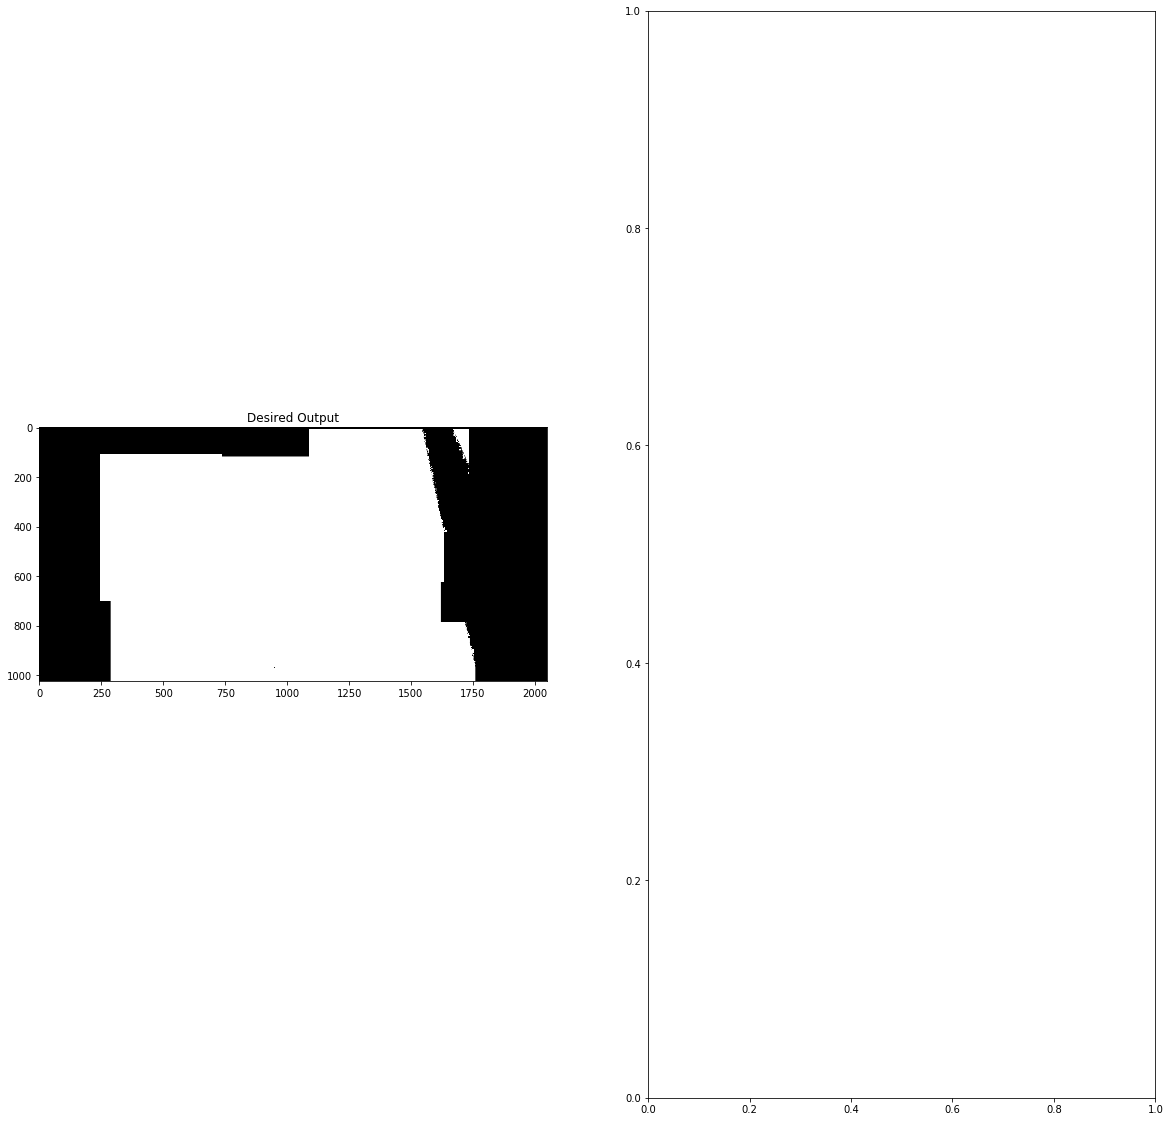

In [17]:
image_slic = seg.slic(img,n_segments=100)
Max = color.label2rgb(image_slic, img, kind='max')
Min = color.label2rgb(image_slic, img, kind='min')
Avg = color.label2rgb(image_slic, img, kind='avg')
cv.cvtColor(img, cv.COLOR_BGR2GRAY)
MaxpCol =cv.cvtColor(Max, cv.COLOR_BGR2GRAY)
MinPCol =cv.cvtColor(Min, cv.COLOR_BGR2GRAY)
AvgPCol =cv.cvtColor(Avg, cv.COLOR_BGR2GRAY)
f, ax = plt.subplots(1,2, figsize=(20, 20))
ax[0].imshow(FiLabels[TESTNUM], cmap='gray')
ax[0].set_title('Desired Output')
ax[1].imshow()
ax[1].set_title('Avg colors')
plt.show()
f, ax = plt.subplots(1,2, figsize=(20, 20))
ax[0].imshow(Max, cmap='gray')
ax[0].set_title('Max')
ax[1].imshow()
ax[1].set_title('Avg colors')
plt.show()
f, ax = plt.subplots(1,2, figsize=(20, 20))
ax[0].imshow(FiLabels[TESTNUM], cmap='gray')
ax[0].set_title('Desired Output')
ax[1].imshow()
ax[1].set_title('Avg colors')
plt.show()
f, ax = plt.subplots(1,2, figsize=(20, 20))
ax[0].imshow(FiLabels[TESTNUM], cmap='gray')
ax[0].set_title('Desired Output')
ax[1].imshow()
ax[1].set_title('Avg colors')
plt.show()